# Predicting the severity of car accidents

## Introduction

Between the 2004 and 2018 ocurred around 225000 collision in seattle, Canada. During this years a lot of information was registered and organized into a database, that contains about 41 attributes. One of those attributes describes the severity of the collision, that can be labeled from collisions that only caused propierty damage to collisions that caused fatallities. The autorithies of seattle made an effort in order to save a lot of data for each collison. For example, we can know about the number of vehicles and the type of those vehicles involved in the accident, the amount of people involved in the crash, the weather and road conditions,the location of the accidents, and even we can know if the speeding or the influence of some substances took part in the accident. However, there is a lot of missing data that will have to be evaluated towards extracting and analising information from this database.

Having all this information, we can think about the posible benefits of usign data science and machine learning techniques to find the especific conditions that increases the posibility of fatallities in one collison. Having this information we could be able to predict the severity of one accident just by having information about the traffic of the city, the roads and the available information in the database, therefore i expect this to be useful for the ones interested in the collisions, and how we can predict them and more important which conditions that are under our control we can improve to prevent the accidents or at least having the smallest amount of casualties.

This work it's a oportunity to the public entities around the world to have a deeper knowledge of the variables involved in the accidents in order to save lives likewise the insurance companies could be interested in knowing how to reduce the damage in accidents.

## Data Analysis

This notebooks contains the exploratory data analysis of the data used to predict the severity of the collisions in the city of Seattle in Canada. The main objective is to build a highly accurated machine learning model using the available data.The database used was provided by the city if seattle and can be found at: http://data-seattlecitygis.opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0 
The first setep it's to install and import the necessary libraries to make the analysis and ploting of the data:

In [3]:
%%capture
! pip install seaborn
! pip install dexplot

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import io
import requests
from scipy import stats
import datetime
import dexplot as dxp
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
import timeit
from sklearn import svm

Then i loaded the data a decoded it:

In [2]:
url="https://opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0.csv"
s=requests.get(url).content
c=pd.read_csv(io.StringIO(s.decode('utf-8')))

In [3]:
c.head()

,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,-122.356511,47.517361,1,327920,329420,3856094,Matched,Intersection,34911.0,17TH AVE SW AND SW ROXBURY ST,...,Dry,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,-122.361405,47.702064,2,46200,46200,1791736,Matched,Block,NaN,HOLMAN RD NW BETWEEN 4TH AVE NW AND 3RD AVE NW,...,Wet,Dusk,NaN,5101020.0,NaN,13,From same direction - both going straight - bo...,0,0,N
2,-122.317414,47.664028,3,1212,1212,3507861,Matched,Block,NaN,ROOSEVELT WAY NE BETWEEN NE 47TH ST AND NE 50T...,...,Dry,Dark - Street Lights On,NaN,NaN,NaN,30,From opposite direction - all others,0,0,N
3,-122.318234,47.619927,4,327909,329409,EA03026,Matched,Intersection,29054.0,11TH AVE E AND E JOHN ST,...,Wet,Dark - Street Lights On,NaN,NaN,NaN,0,Vehicle going straight hits pedestrian,0,0,N
4,-122.351724,47.560306,5,104900,104900,2671936,Matched,Block,NaN,WEST MARGINAL WAY SW BETWEEN SW ALASKA ST AND ...,...,Ice,Dark - Street Lights On,NaN,9359012.0,Y,50,Fixed object,0,0,N


## Data exploration

In this section i chose the variables that i'm going to use to make the prediction, i took the variables that showed a relation with the target, and didn't have a lot of null values.

In [4]:
c.drop(c.columns.difference(['SEVERITYCODE','ADDRTYPE','WEATHER','ROADCOND','LIGHTCOND','VEHCOUNT','COLLISIONTYPE','INCDATE','PEDCOUNT']), 1, inplace=True)
c.head()

,ADDRTYPE,SEVERITYCODE,COLLISIONTYPE,PEDCOUNT,VEHCOUNT,INCDATE,WEATHER,ROADCOND,LIGHTCOND
0,Intersection,1,Angles,0,2,2020/01/19 00:00:00+00,Clear,Dry,Daylight
1,Block,1,Rear Ended,0,2,2005/04/11 00:00:00+00,Raining,Wet,Dusk
2,Block,2,Head On,0,2,2013/03/31 00:00:00+00,Clear,Dry,Dark - Street Lights On
3,Intersection,2,Pedestrian,1,1,2020/01/06 00:00:00+00,Raining,Wet,Dark - Street Lights On
4,Block,2,Other,0,1,2009/12/25 00:00:00+00,Clear,Ice,Dark - Street Lights On


Here i droped the null values in the dataframe and reseted the index

In [5]:
c.isnull().sum()
c.dropna(inplace=True)
c= c.reset_index(drop=True)
c.isnull().sum()

ADDRTYPE         0
SEVERITYCODE     0
COLLISIONTYPE    0
PEDCOUNT         0
VEHCOUNT         0
INCDATE          0
WEATHER          0
ROADCOND         0
LIGHTCOND        0
dtype: int64

I droped the rows with severity unknown, i can't get information from that, also i checked for the quantity of each severity registered

In [6]:
c = c[c.SEVERITYCODE != '0']
c['SEVERITYCODE'].value_counts()

1     131994
2      57604
2b      3049
3        339
Name: SEVERITYCODE, dtype: int64

I took the date data and convert it to a number that indicates the day of the week

In [7]:
c['INCDATE'], c['B'] = c['INCDATE'].str.split(' ', 1).str
del c['B']
c['INCDATE'] =  pd.to_datetime(c['INCDATE']).dt.dayofweek
c.head()

<ipython-input-7-93f844ff2f4e>:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  c['INCDATE'], c['B'] = c['INCDATE'].str.split(' ', 1).str


,ADDRTYPE,SEVERITYCODE,COLLISIONTYPE,PEDCOUNT,VEHCOUNT,INCDATE,WEATHER,ROADCOND,LIGHTCOND
0,Intersection,1,Angles,0,2,6,Clear,Dry,Daylight
1,Block,1,Rear Ended,0,2,0,Raining,Wet,Dusk
2,Block,2,Head On,0,2,6,Clear,Dry,Dark - Street Lights On
3,Intersection,2,Pedestrian,1,1,0,Raining,Wet,Dark - Street Lights On
4,Block,2,Other,0,1,4,Clear,Ice,Dark - Street Lights On


Then i just counted the number of variables of each row to drop the values of which don't provide clear informartion

In [8]:
print(c['ADDRTYPE'].value_counts())
print(c['WEATHER'].value_counts())
print(c['ROADCOND'].value_counts())
print(c['LIGHTCOND'].value_counts())
print(c['COLLISIONTYPE'].value_counts())
print(c['INCDATE'].value_counts())
c = c[c.WEATHER != 'Unknown'] 
c = c[c.WEATHER != 'Other'] 
c = c[c.COLLISIONTYPE != 'Other'] 
c = c[c.ROADCOND != 'Unknown'] 
c = c[c.ROADCOND != 'Other'] 
c = c[c.LIGHTCOND != 'Unknown'] 
c = c[c.LIGHTCOND != 'Other'] 
c = c[c.LIGHTCOND != 'Dark - Unknown Lighting'] 
c = c[c.LIGHTCOND != 'COLLISIONTYPE']

Block           126304
Intersection     65927
Alley              755
Name: ADDRTYPE, dtype: int64
Clear                       114149
Raining                      33859
Overcast                     28384
Unknown                      14097
Snowing                        908
Other                          818
Fog/Smog/Smoke                 571
Sleet/Hail/Freezing Rain       115
Blowing Sand/Dirt               49
Severe Crosswind                26
Partly Cloudy                   10
Name: WEATHER, dtype: int64
Dry               127855
Wet                48467
Unknown            14065
Ice                 1215
Snow/Slush          1002
Other                128
Standing Water       115
Sand/Mud/Dirt         75
Oil                   64
Name: ROADCOND, dtype: int64
Daylight                    118803
Dark - Street Lights On      49854
Unknown                      12657
Dusk                          6025
Dawn                          2596
Dark - No Street Lights       1568
Dark - Street Lights Off 

Here i printed each value of the variables grouped with the normalized severity code to visualize the distribution of the data


In [9]:
print(c.groupby(['ADDRTYPE'])['SEVERITYCODE'].value_counts(normalize=True))
print(c.groupby(['WEATHER'])['SEVERITYCODE'].value_counts(normalize=True))
print(c.groupby(['ROADCOND'])['SEVERITYCODE'].value_counts(normalize=True))
print(c.groupby(['LIGHTCOND'])['SEVERITYCODE'].value_counts(normalize=True))
print(c.groupby(['VEHCOUNT'])['SEVERITYCODE'].value_counts(normalize=True))
print(c.groupby(['INCDATE'])['SEVERITYCODE'].value_counts(normalize=True))

ADDRTYPE      SEVERITYCODE
Alley         1               0.831933
              2               0.162465
              2b              0.005602
Block         1               0.723720
              2               0.263594
              2b              0.011609
              3               0.001076
Intersection  1               0.536814
              2               0.436997
              2b              0.023786
              3               0.002402
Name: SEVERITYCODE, dtype: float64
WEATHER                   SEVERITYCODE
Blowing Sand/Dirt         1               0.717949
                          2               0.282051
Clear                     1               0.651498
                          2               0.329824
                          2b              0.016991
                          3               0.001687
Fog/Smog/Smoke            1               0.668213
                          2               0.324826
                          3               0.004640
           

Then i made a barplot for each variable in comparison to the severity code

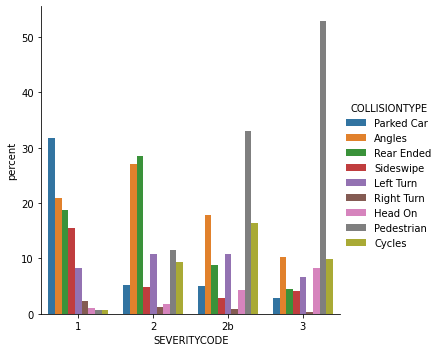

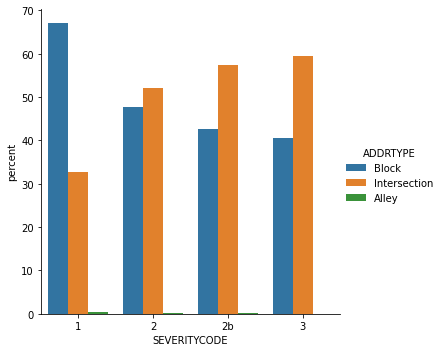

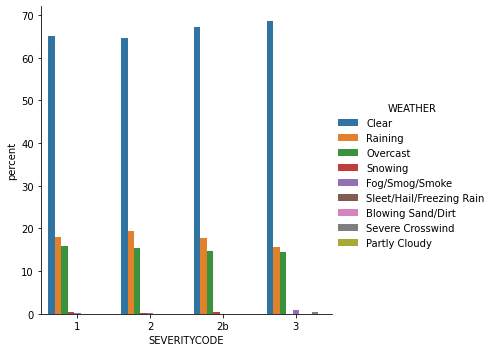

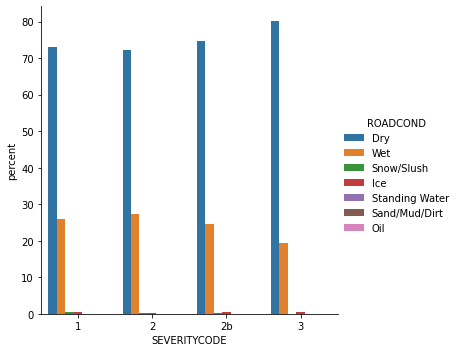

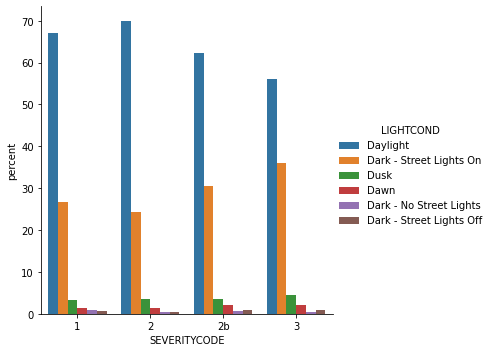

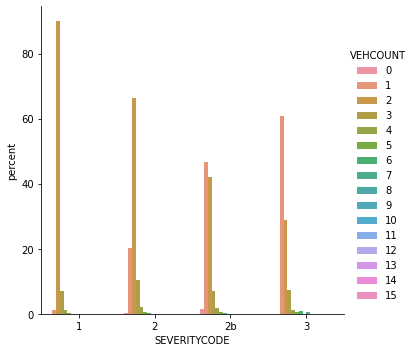

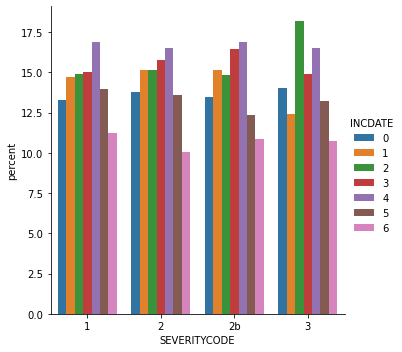

In [10]:
x = 'SEVERITYCODE'
(c.groupby(x)['COLLISIONTYPE'].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x=x,y='percent',hue='COLLISIONTYPE',kind='bar'))
(c.groupby(x)['ADDRTYPE'].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x=x,y='percent',hue='ADDRTYPE',kind='bar'))
(c.groupby(x)['WEATHER'].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x=x,y='percent',hue='WEATHER',kind='bar'))
(c.groupby(x)['ROADCOND'].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x=x,y='percent',hue='ROADCOND',kind='bar'))
(c.groupby(x)['LIGHTCOND'].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x=x,y='percent',hue='LIGHTCOND',kind='bar'))
(c.groupby(x)['VEHCOUNT'].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x=x,y='percent',hue='VEHCOUNT',kind='bar'))
(c.groupby(x)['INCDATE'].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x=x,y='percent',hue='INCDATE',kind='bar'))

I decided to group each category of the variables in order to take the most relevant categories to make the predictions,also i enconded the categories into numbers to ease the future implementation of the predicitive model, i grouped the collision address type or ADDRTYPE as shown below:

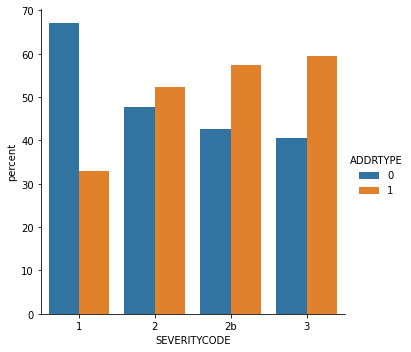

In [11]:
c['ADDRTYPE'].replace(to_replace=['Block','Intersection','Alley'], value=[0,1,2],inplace=True)
c['ADDRTYPE'] = c['ADDRTYPE'].apply(lambda x: 1 if (x>=1)  else 0)
(c.groupby(x)['ADDRTYPE'].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x=x,y='percent',hue='ADDRTYPE',kind='bar'))

Then i grouped each category of the variables for the road conditions in the collision, i decided to take 0 as dry and 1 as not dry, which includes different conditions, as you can see in the results below:

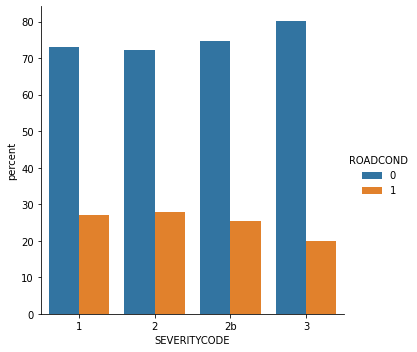

In [12]:
c['ROADCOND'].replace(to_replace=['Dry','Wet','Ice','Snow/Slush','Standing Water','Sand/Mud/Dirt','Oil'], value=[0,1,2,3,4,5,6],inplace=True)
c['ROADCOND'] = c['ROADCOND'].apply(lambda x: 1 if (x>=1)  else x)
(c.groupby(x)['ROADCOND'].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x=x,y='percent',hue='ROADCOND',kind='bar'))

In this point i organized the light conditions of the roads grouped by severity code, i took 3 categories to discard the categories that are not very common.

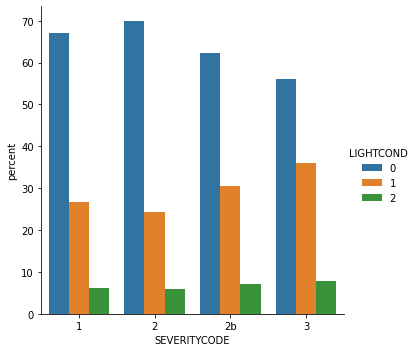

In [13]:
c['LIGHTCOND'].replace(to_replace=['Daylight','Dark - Street Lights On','Dusk','Dawn','Dark - No Street Lights','Dark - Street Lights Off'], value=[0,1,2,3,4,5],inplace=True)
c['LIGHTCOND'] = c['LIGHTCOND'].apply(lambda x: 2 if (x>=2)  else x)
(c.groupby(x)['LIGHTCOND'].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x=x,y='percent',hue='LIGHTCOND',kind='bar'))

Finally, i reduced the category for the number of the vehicles that didn't give me relevant information about the severity of the information.

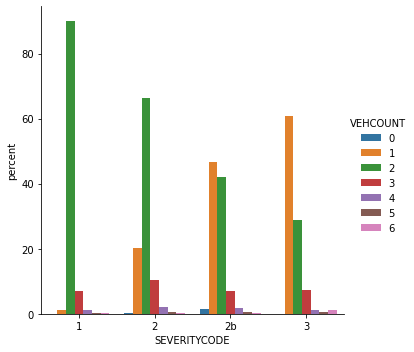

In [14]:
c['VEHCOUNT'] = c['VEHCOUNT'].apply(lambda x: 6 if (x>=6)  else x)
(c.groupby(x)['VEHCOUNT'].value_counts(normalize=True).mul(100).rename('percent').reset_index().pipe((sns.catplot,'data'), x=x,y='percent',hue='VEHCOUNT',kind='bar'))

## Metodology

To find the best algorithm to predict the values, first i finshed the enconding of the variables, then i tried different
methods to predict the severity of the accidents, i used KNN and then a desicion tree, looping trough different levels of
depth and number of clusters to find the best option. I also tried to use an implementation of SVM looping through differente
kernels.

In [15]:
c.head()

,ADDRTYPE,SEVERITYCODE,COLLISIONTYPE,PEDCOUNT,VEHCOUNT,INCDATE,WEATHER,ROADCOND,LIGHTCOND
0,1,1,Angles,0,2,6,Clear,0,0
1,0,1,Rear Ended,0,2,0,Raining,1,2
2,0,2,Head On,0,2,6,Clear,0,1
3,1,2,Pedestrian,1,1,0,Raining,1,1
5,0,1,Rear Ended,0,2,3,Clear,0,0


Until this point i have enconded some of the variables and then i decided to encode the variables that weren't encoded in the previous section.

In [16]:
Feature = c[['ADDRTYPE','PEDCOUNT','VEHCOUNT','INCDATE','ROADCOND','LIGHTCOND']]
Feature = pd.concat([Feature,pd.get_dummies(c['COLLISIONTYPE'])], axis=1)
Feature = pd.concat([Feature,pd.get_dummies(c['WEATHER'])], axis=1)
Feature.head()

,ADDRTYPE,PEDCOUNT,VEHCOUNT,INCDATE,ROADCOND,LIGHTCOND,Angles,Cycles,Head On,Left Turn,...,Sideswipe,Blowing Sand/Dirt,Clear,Fog/Smog/Smoke,Overcast,Partly Cloudy,Raining,Severe Crosswind,Sleet/Hail/Freezing Rain,Snowing
0,1,0,2,6,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,2,0,1,2,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,2,6,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
3,1,1,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,0,0,2,3,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


I labeled the data in order to split into train and test sets to train the models:

In [17]:
X = Feature
y = c['SEVERITYCODE'].values
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (121084, 24) (121084,)
Test set: (30272, 24) (30272,)


The first model that i implemented was a KNN to evaluate it's behaviour with the data

In [35]:
def func():
    for n in range(1,10):
        neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
        yhat_K = neigh.predict(X_test)
        print("Train set Accuracy for K=",n, metrics.accuracy_score(y_test, yhat_K))
execution_time = timeit.timeit(func, number=1)

Train set Accuracy for K= 1 0.6360002642706131
Train set Accuracy for K= 2 0.6839323467230444
Train set Accuracy for K= 3 0.666622621564482
Train set Accuracy for K= 4 0.6885240486257929
Train set Accuracy for K= 5 0.679406712473573
Train set Accuracy for K= 6 0.6878303382663847
Train set Accuracy for K= 7 0.6833047040169133
Train set Accuracy for K= 8 0.6964521670190275
Train set Accuracy for K= 9 0.6884910147991543


Then i decided to test the performance of a classifier based on the desicion tree

In [18]:
for n in range(4,12):
    paidTree = DecisionTreeClassifier(criterion="entropy", max_depth = n)
    paidTree.fit(X_train,y_train)
    predTree = paidTree.predict(X_test)
    print("Train set Accuracy a depth of=",n, metrics.accuracy_score(y_test, predTree))

Train set Accuracy a depth of= 4 0.7182544926004228
Train set Accuracy a depth of= 5 0.7181553911205074
Train set Accuracy a depth of= 6 0.7190473044397463
Train set Accuracy a depth of= 7 0.7189482029598309
Train set Accuracy a depth of= 8 0.7188491014799154
Train set Accuracy a depth of= 9 0.7194106765327696
Train set Accuracy a depth of= 10 0.7191464059196617
Train set Accuracy a depth of= 11 0.7187830338266384


As you can see, the desicion tree had a best performance with the data, or at least with the measure of the accuracy. Another
important feature of each algorithm its the time of exectuion so decided to use timeit to measure it. The used implementation
of KNN resulted to be extremely slow with a execution time of nearly 14 minutes in comparison with the desicion tree which only took about 3 seconds to complete and had a best performance with the data. 

I tried to train and then predict a model with the SVM implementation used in sklearn but it didn't work, because it took a lot of time only to complete the training and prediction of the model with a lineal kernel, so i didn't tried with a polynomial or a rbf kernel. I think that it was for the size of the dataset, it would be necessary to reduce the size of the data set or find a faster implementation of the algorithm in order to use that method with this dataset.

In [ ]:
kernel = ['linear','poly','rbf']
for x in kernel:
    clf = svm.SVC(kernel=x)
    clf.fit(X_train, y_train) 
    yhat_SVM = clf.predict(X_test)
    print("Train set Accuracy for Kernel",x, metrics.accuracy_score(y_test,  yhat_SVM))

In [1]:
intentar regresión lineal 

SyntaxError: invalid syntax (<ipython-input-1-5d71f270d7a3>, line 1)

## Results

## Discussion

## Conclusion